### **Q1. Exploratory Data Analysis (EDA)**

#### **OBJECTIVE**
This Jupyter Notebook will seek to conduct an EDA on the dataset from MN Department of Transportation and present its findings of the analysis at the end.

#### **GENERAL OVERVIEW OF EDA**
#####  **1) CHECKING IF THE DATA IS INTUITIVE**
Using domain knowledge, we will analyse the data and pick out areas that might require further analysis (e.g. if data seems incorrect, identify outliers etc.)
#####  **2) UNIVARIATE AND BIVARIATE ANALYSIS**
We will analyse each feature in detail and conduct feature cleaning/engineering (if needed).
We will analyze pairs of features to obtain further insight on the relationship between them and conduct feature cleaning/engineering (if needed).
#####  **3) SUMMARY OF ANALYSIS AND IMPLICATIONS**
We will then summarize our findings above and identify things which we can do based on our findings.

In [1]:
# Importing the libraries

# System
import io, os, sys, datetime, math, calendar

# Data Manipulation
import numpy as np
import pandas as pd

# Data Preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,precision_score,f1_score,r2_score,explained_variance_score
from xgboost import XGBClassifier, XGBRegressor

# Visualisation
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sn

The scikit-learn version is 0.21.3.


#####  **1) CHECKING IF THE DATA IS INTUITIVE**

**Summary:** 
<br>This dataset provides hourly traffic volume for a city, including features indicating holidays and weather conditions. 
 
**Features:** 
<br>`holiday`​: US national and regional holidays 
<br>`temp`​: average temperature in Kelvin (K) 
<br>`rain_1h`​: rain that occured in the hour (mm) 
<br>`snow_1h`​: snow that occured in the hour (mm) 
<br>`clouds_all`​: percentage of cloud cover 
<br>`weather main`:​ textual description of current weather 
<br>`weather_description`​: longer textual description of current weather 
<br>`date_time`:​ hour of the data collected in local time 
 
**Output:**
<br>`traffic_volume`​: hourly I-94 reported westbound traffic volume 

In [748]:
# Importing the dataset
data_url = 'https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv'
dataset = pd.read_csv(data_url)

In [749]:
# Checking the first 10 lines for the dataset for intuition
dataset.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,New Years Day,263.49,0.0,0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372
5,None,262.40,0.0,0,40,Snow,heavy snow,2013-01-01 05:00:00,419
6,None,261.42,0.0,0,20,Clouds,few clouds,2013-01-01 06:00:00,640
7,None,260.66,0.0,0,1,Clear,sky is clear,2013-01-01 07:00:00,745
8,None,260.29,0.0,0,20,Clouds,few clouds,2013-01-01 08:00:00,939
9,None,260.19,0.0,0,20,Clouds,few clouds,2013-01-01 09:00:00,1243


In [750]:
# Checking the details of the dataset for intuition
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8573 entries, 0 to 8572
Data columns (total 9 columns):
holiday                8573 non-null object
temp                   8573 non-null float64
rain_1h                8573 non-null float64
snow_1h                8573 non-null int64
clouds_all             8573 non-null int64
weather_main           8573 non-null object
weather_description    8573 non-null object
date_time              8573 non-null object
traffic_volume         8573 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 602.9+ KB


In [751]:
# Checking the details of the dataset for intuition
dataset.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,8573.000000,8573.000000,8573.0,8573.000000,8573.000000
mean,278.976352,0.161284,0.0,52.560947,3286.762160
std,13.322459,1.439626,0.0,37.470062,2028.322769
min,244.820000,0.000000,0.0,0.000000,164.000000
25%,269.460000,0.000000,0.0,1.000000,1193.000000
50%,277.330000,0.000000,0.0,64.000000,3344.000000
75%,290.400000,0.000000,0.0,90.000000,5001.000000
max,308.240000,55.630000,0.0,100.000000,7217.000000


From the snapshots of the dataset provided above, please refer to the table below for the summary of our observations. For each observation, we will analyze them in further detail when we conduct our univariate / bivariate analysis.

| S/N | Findings | Actions to be taken |
| :-: | :-- | :-: |
|| **Findings from head()** ||
| 1 | weather_description seems to be extremely similar to weather_main <br> (possible that weather_main might be redundant if weather description provides greater details) | bivariate analysis |
| 2 | in row 2, weather_description is "heavy snow" while snow_1h is 0 <br> (possible incorrect data / data was previously pre-processed. There might be similar issue for rain_1h) | univariate analysis |
| 3 | in row 0, holiday is "New Years Day", but in row 1, it is "None" <br> (since we are predicting traffic volume, the period before and after a holiday is also important. We might need to create additional features to take into account the effect of the period before and after a holiday on traffic volumn ) | univariate analysis |
| 4 | date_time only has the date and hour <br> (since we are predicting traffic volume, the day of the week is also an important feature (e.g. traffic can be higher for weekdays vs weekend. We might need to create additional features that will improve the model) | univariate analysis |
|| **Findings from info()** ||
| 5 | date_time type is "object" <br> (might need to convert to "datetime") | univariate analysis |
| 6 | there are no null values <br> (data might have been pre-processed, null data might have been replaced (e.g. replaced with mean, median, -1, -999 etc.)) | to check with data provider |
|| **Findings from describe()** ||
| 7 | snow_1h has zeros for the entire dataset even when weather_description is "heavy snow" (as mentioned in findings from head()) <br> (possible incorrect data, will not be useful for model prediction since the values are all zeros.) | univariate analysis and <br> to check with data provider|

#####  **2) UNIVARIATE AND BIVARIATE ANALYSIS**
For our dataset, we can categorise into 3 main categories for our analysis:
<br> **Numerical:** feature that contains numeric values
<br> **Categorical:** feature that contains categories or texts 
<br> **Time_Date:** feature that contains time/date

For this section we will:
<br> **a) conduct relevant analysis based on the category**
<br> **b) conduct feature cleaning and engineering based on findings from part 1 and part 2a (if required)**

In [752]:
# Defining a function for plotting distribution
def plot_distribution(dataset, columns, cols=5, rows=2, width=20 , height=10, hspace=0.4, wspace=0.1):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        #if feature is categorical, to plot countplot
        if dataset.dtypes[column] == np.object:
            sn.countplot(y=dataset[column])
            plt.xticks(rotation=25)
        #if feature is numerical, to plot boxplot
        else:
            sn.boxplot(dataset[column])
            plt.xticks(rotation=25)

**NUMERICAL FEATURES:** 
<br> "temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"

**a) Analysis of numerical features**

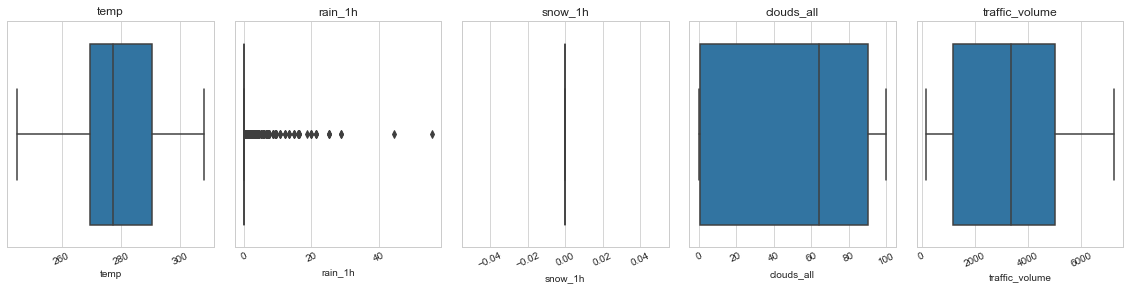

In [753]:
# Plot distribution of all numerical features for analysis
num_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']
plot_distribution(dataset, num_features, cols=5, rows=2, width=20 , height=10, hspace=0.4, wspace=0.1)

From the boxplot, there are no issues highlighted for "temp", "clouds_all" and "traffic_volume. As for rain_1h and snow_1h, our observations are as follows: 

| S/N | Findings | Actions to be taken |
| :-: | :-- | :-: |
|| **Findings for boxplot of rain_1h** ||
| 1 | We can see that majority of its datapoints are at 0, resulting in datapoints that are above 0 to be classified as outliers. There do not seem to be an issue with this as majority datapoints can be measured when there is no rain. <br> In addition, the highest point for rain_1h is slightly below 60mm/hour. From our research online, if the there is violent rainfall, 60mm/hour is attainable. <br> (Since the datapoints for when rain_1h are limited, we should not remove these outliers, instead we will choose a decision tree model for our prediction as it is robust towards outliers) | choose a decision tree based <br> machine learning model |
|| **Findings for boxplot of snow_1h** ||
| 2 | We can see that all datapoints are 0 which coincides with the findings above in part 1. | to remove and <br> to check with data provider |

**b) Feature cleaning and engineering**
<br> Based on our findings above, we will conduct the following cleaning/engineering processes for the following features stated
>**Cleaning:**
<br> snow_1h: the data was all zeroes, to remove the data since it will have no effect on the model

**Feature:** snow_1h
<br> As mentioned above, we will proceed to remove snow_1h as a data of all zeroes has no effect on our model

In [754]:
# Drop columns which are redundant and check that it is properly dropped
dataset = dataset.drop(["snow_1h"], axis = 1)

dataset.head()

,holiday,temp,rain_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,New Years Day,263.49,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


**CATEGORICAL FEATURES:** 
<br> "holiday", "weather_main", "weather_description"

**a) Analysis of categorical features**

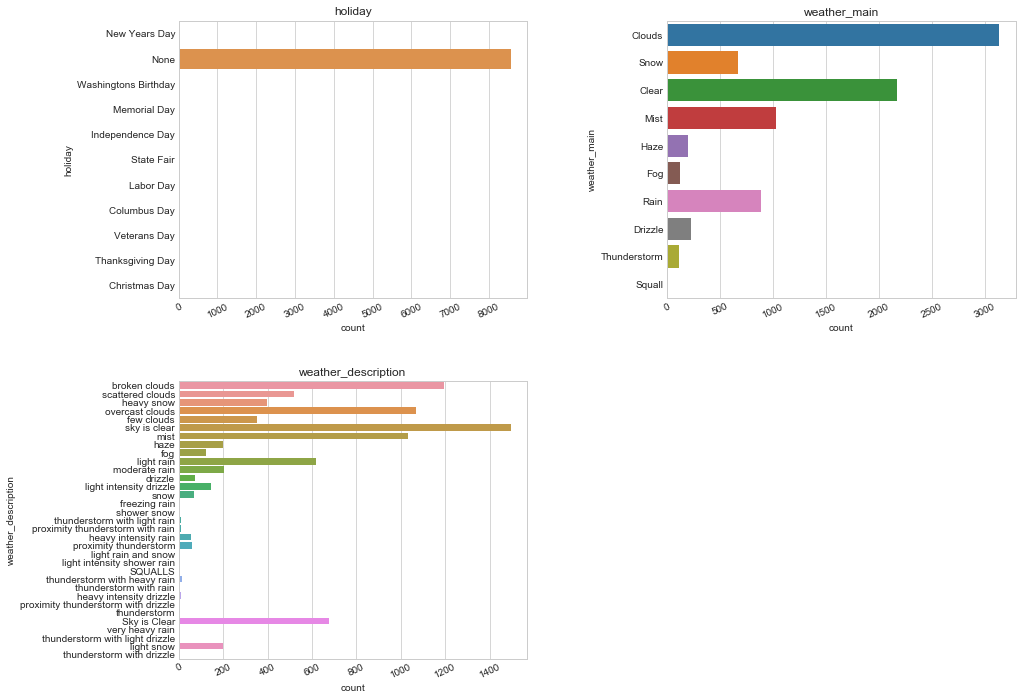

In [755]:
# Plot distribution of all categorical features
num_features = ["holiday", "weather_main", "weather_description"]
plot_distribution(dataset, num_features, cols=2, rows=2, width=15, height=25, hspace=0.3, wspace=0.4)

From the countplot, our observations are as follows: 

| S/N | Findings | Actions to be taken |
| :-: | :-- | :-: |
|| **Findings for countplot of holiday** ||
| 1 | We can see that majority of its datapoints are "None". As mentioned in part 1, the periods before and after holiday is important as it is the period people usually travels. | create additional features |
|| **Findings for countplot of weather_main and weather_description** ||
| 2 | We can see that all weather_description seems to be more informative than weather_main, as it splits weather_main into small "subsets". As mentioned in part 1, weather_main seems redundant. | bivariate analysis |

**b) Feature cleaning and engineering**
<br> Based on our findings above, we will conduct the following cleaning/engineering processes for the following features stated

>**Engineering:**
<br> holidays: create additional features for the time period before and after holidays
<br> weather_main: to remove weather_main

**Feature:** holidays
<br> As mentioned above, we will create additional features for the time period before and after holidays as they are useful features for our model.

We will create 2 features, "24h_before_holiday" and "24h_after_holiday". Since people usually travels within 24 hours before and after holidays, our additional features will be capped at 24 hours. 
<br> (e.g. Under the new feature "24h_before_holiday, if a time period is within 24hours before a holiday, we will assign it a value of True.)

In [756]:
# Before creating a function to create the additional features, 
# we should first create a function to check if there are holidays that are back to back (e.g. within 24 hours apart from each other) as this might cause error
def backtoback_holidays (dataset, column, hours=24):
    holiday_row = []
    for index, row in dataset[column].to_frame().iterrows():
        if row[column] != "None":
            print (row[column], "is at line", index)
            holiday_row.append(index)
    print("\n", holiday_row)
    for i in range(len(holiday_row)-1):
        if holiday_row[i] + hours >= holiday_row[i+1]:
            print ("Error identified at line: ", holiday_row[i], 'and at line:', holiday_row[i+1])

backtoback_holidays(dataset, "holiday")

New Years Day is at line 0
Washingtons Birthday is at line 1138
Memorial Day is at line 3871
Independence Day is at line 4855
State Fair is at line 6016
Labor Day is at line 6183
Columbus Day is at line 6896
Veterans Day is at line 7209
Thanksgiving Day is at line 7622
Christmas Day is at line 8380

 [0, 1138, 3871, 4855, 6016, 6183, 6896, 7209, 7622, 8380]


In [757]:
# From the above, we can see that no error is identified. 
# Next, we will create the additional features "hours_before_holiday" and "hours_after_holiday", and remove "holiday"
def add_features_holiday (dataset, column, hours=24):
    # Create blank list for hours_before and hours_after, if the row is within 24 hours from a holiday, we will append the row number to it
    hours_before = []
    hours_after = []
    # Create blank list for hours_holiday, if the row is the holiday itself, we will append the row number to it
    hours_holiday = []
    # Create numpy arrays of False, if row number is within 24 hours from a holiday, we will change it to True
    before_holiday = np.zeros(len(dataset[column])).astype(dtype=bool)
    after_holiday = np.zeros(len(dataset[column])).astype(dtype=bool)
    for index, row in dataset[column].to_frame().iterrows():
        # If there is a holiday, append the relevant number to hours_holiday
        if row[column] != "None":
            hours_holiday.append(index)
    
    # Append the relevant row humbers to hours_before and hours_after
    for i in hours_holiday:
        for hour in range(0, hours+1):
            hours_before.append(i - hour)
            hours_after.append(i + hour)
            
    # Remove the row rumbers that are out of range
    hours_before = np.asarray(hours_before)
    hours_before = hours_before[(hours_before>=0) & (hours_before<=len(dataset[column]))]
    hours_after = np.asarray(hours_after)
    hours_after = hours_after[(hours_after>=0) & (hours_after<=len(dataset[column]))]
    
    # Change numpy array to true, if the respective row number within 24 hours from a holiday
    before_holiday[hours_before.tolist()] = True
    after_holiday[hours_after.tolist()] = True
    
    # Convert hours_before_holiday and hours_after_holiday to dataframe and merge to original dataset
    before_holiday = pd.DataFrame(before_holiday,  columns=['before_holiday'])
    after_holiday = pd.DataFrame(after_holiday,  columns=['after_holiday'])
    
    dataset =  pd.concat([dataset, before_holiday], axis=1, sort=False)
    dataset =  pd.concat([dataset, after_holiday], axis=1, sort=False)
    
    # Drop column as relevant features were already extracted and feature takes into account column
    dataset = dataset.drop([column], axis = 1)
            
    return dataset

dataset = add_features_holiday(dataset, "holiday")

dataset.head()

,temp,rain_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,before_holiday,after_holiday
0,263.49,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439,True,True
1,263.78,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502,False,True
2,264.16,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933,False,True
3,263.95,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576,False,True
4,263.65,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372,False,True


**Feature:** weather_main
<br> As mentioned above, weather_main seems to be redundant as weather_description seems to be a 'subset' if weather_main and is hence more informative.

However, we have to first verify whether weather_description is a 'subset' of weather_main. This will ensure that we do not remove important data.
<br> (e.g. if weather_main data is "Clouds", weather_description should be clouds related such as  "overcast clouds".)

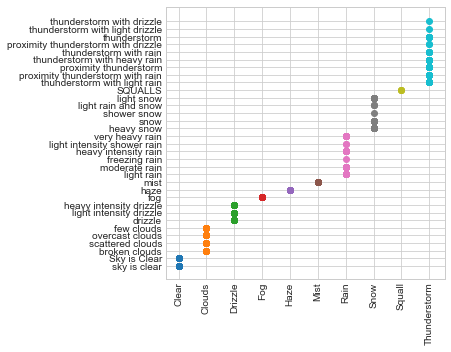

In [758]:
# We will create plot a scatterplot to check for the above

# First, we extract the relevant data from our dataset (i.e. weather_main and weather_description)
weather_data = dataset.iloc[:, 3:5].values
weather_data = pd.DataFrame(weather_data)

# Next, we plot weather_data on a scatterplot
plt.figure(figsize=(5,5))
for i, weather in enumerate(np.unique(weather_data[0].to_numpy())):
    plt.scatter(y=weather_data[1][weather_data[0]==weather],x=weather_data[0][weather_data[0]==weather])
    plt.xticks(rotation=90)

From the scatterplot, we are certain that weather_description is a 'subset' of weather_main. Therefore, we will proceed to remove weather_main.

In [759]:
# Drop columns which are redundant and check that it is properly dropped
dataset = dataset.drop(["weather_main"], axis = 1)

dataset.head()

,temp,rain_1h,clouds_all,weather_description,date_time,traffic_volume,before_holiday,after_holiday
0,263.49,0.0,58,broken clouds,2013-01-01 00:00:00,1439,True,True
1,263.78,0.0,40,scattered clouds,2013-01-01 01:00:00,1502,False,True
2,264.16,0.0,75,heavy snow,2013-01-01 02:00:00,933,False,True
3,263.95,0.0,90,overcast clouds,2013-01-01 03:00:00,576,False,True
4,263.65,0.0,90,overcast clouds,2013-01-01 04:00:00,372,False,True


**DATE_TIME FEATURES:** 
<br> "date_time"

**a) Analysis of date_time features**
<br> We won't be plotting a graph for date_time, as bivariate analysis suits date_time features better. Instead with what we discovered from part 1, we will proceed to feature cleaning and engineering.

**b) Feature cleaning and engineering**
<br> Based on our findings above, we will conduct the following cleaning/engineering processes for the following features stated
>**Cleaning:**
<br> date_time: incorrect datatype, to convert from object to date_time datatype

>**Engineering:**
<br> date_time: create additional features for the days of the week

**Feature:** date_time
<br> As mentioned above, we will first convert the datatype to date_time then create additional features for the days of the week.

Next, we will be creating 4 new features, "year", "month", "day_of_the_week" and "time_period" to replace date_time as I believe these features seperately will be more informative in predicting traffic volume as compared to a single date_time feature.

In [760]:
# We will first convert date_time to date_time datatype
dataset['date_time'] = pd.to_datetime(dataset['date_time'], format="%Y-%m-%d %H:%M:%S")

dataset.head()

,temp,rain_1h,clouds_all,weather_description,date_time,traffic_volume,before_holiday,after_holiday
0,263.49,0.0,58,broken clouds,2013-01-01 00:00:00,1439,True,True
1,263.78,0.0,40,scattered clouds,2013-01-01 01:00:00,1502,False,True
2,264.16,0.0,75,heavy snow,2013-01-01 02:00:00,933,False,True
3,263.95,0.0,90,overcast clouds,2013-01-01 03:00:00,576,False,True
4,263.65,0.0,90,overcast clouds,2013-01-01 04:00:00,372,False,True


In [761]:
# Next, we will create the additional features "year", "month", "day_of_the_week" and "time_period", and remove "date_time"
def add_features_datetime_YMD (dataset, column="date_time", feature_name=["year", "month", "day", "time"]):
    # Create numpy arrays of zeros/empty string, we will replace the values subsequently
    dt_year = np.ones(len(dataset[column]))
    dt_month = np.ones(len(dataset[column]))
    dt_day = []
    dt_time = np.ones(len(dataset[column]))
    
    # Extract the relevant feature from column and update the features to dataset
    for feature in feature_name:
        if feature == "year":
            for index, row in dataset[column].to_frame().iterrows():
                dt_year[index] = row[column].year
            dt_year = pd.DataFrame(data=dt_year, columns=['year'], dtype=np.int64)
            dataset =  pd.concat([dataset, dt_year], axis=1, sort=False)
        elif feature == "month":
            for index, row in dataset[column].to_frame().iterrows():
                dt_month[index] = row[column].month
            dt_month = pd.DataFrame(data=dt_month, columns=['month'], dtype=np.int64)
            dataset =  pd.concat([dataset, dt_month], axis=1, sort=False)
        elif feature == "day":
            for index, row in dataset[column].to_frame().iterrows():
                dt_day.append(row[column].strftime('%A'))
            dt_day = pd.DataFrame(data=dt_day, columns=['day_of_the_week'], dtype=str)
            dataset =  pd.concat([dataset, dt_day], axis=1, sort=False)
        elif feature == "time":
            for index, row in dataset[column].to_frame().iterrows():
                dt_time[index] = row[column].hour
            dt_time = pd.DataFrame(data=dt_time, columns=['time_period'], dtype=np.int64)
            dataset =  pd.concat([dataset, dt_time], axis=1, sort=False)
    
    # Drop column as relevant features were already extracted
    dataset = dataset.drop([column], axis = 1)
            
    return dataset

dataset = add_features_datetime_YMD (dataset, column="date_time", feature_name=["year", "month", "day", "time"])

dataset.head()

,temp,rain_1h,clouds_all,weather_description,traffic_volume,before_holiday,after_holiday,year,month,day_of_the_week,time_period
0,263.49,0.0,58,broken clouds,1439,True,True,2013,1,Tuesday,0
1,263.78,0.0,40,scattered clouds,1502,False,True,2013,1,Tuesday,1
2,264.16,0.0,75,heavy snow,933,False,True,2013,1,Tuesday,2
3,263.95,0.0,90,overcast clouds,576,False,True,2013,1,Tuesday,3
4,263.65,0.0,90,overcast clouds,372,False,True,2013,1,Tuesday,4


In [745]:
# Next, we will carry out binning for the time_period, 
# We will classify time period into bins of Morning, Afternoon, Evening and Night. For each bin, the traffic is expected to be different
dataset["time_period"] = pd.cut(dataset["time_period"], 
                                bins=[0,6,12,18,23], 
                                labels=['Night','Morning','Afternoon','Evening'],
                                include_lowest=True)
dataset.head()

,temp,rain_1h,clouds_all,weather_description,traffic_volume,before_holiday,after_holiday,year,month,day_of_the_week,time_period
0,263.49,0.0,58,broken clouds,1439,True,True,2013,1,Tuesday,Night
1,263.78,0.0,40,scattered clouds,1502,False,True,2013,1,Tuesday,Night
2,264.16,0.0,75,heavy snow,933,False,True,2013,1,Tuesday,Night
3,263.95,0.0,90,overcast clouds,576,False,True,2013,1,Tuesday,Night
4,263.65,0.0,90,overcast clouds,372,False,True,2013,1,Tuesday,Night


#####  **3) SUMMARY OF ANALYSIS AND IMPLICATIONS**
Based on the analysis done in part 1 and 2 above, please refer to the table below for the summary of our analysis and actions taken and further actions to be taken (if any)
<br> We will be arranging the findings by features:

| Features | Analysis and Actions Taken | Actions to be taken |
| :-: | :-- | :-: |
|| **NUMERICAL FEATURES** ||
| "temp" | no actions taken | nil |
| "rain_1h" |  based on the boxplot and our analysis, we noticed that there are several outliers that should not be removed. Intead, we will choose a decision tree model for our prediction as it is robust towards outliers. | choose a decision tree based <br> machine learning model |
| "snow_1h" | this feature was removed as the data was all zeros and hence will have no effect on our machine learning model. To check with data provider on how the data collection process. | to check with data provider |
| "clouds_all" | no actions taken | nil |
| "traffic_volume" | no actions taken | nil |
|| **CATEGORICAL FEATURES** ||
| "holiday" | this feature is removed and replaced with 2 features "24h_before_holiday" and "24h_after_holiday". We believe that the periods before and after holiday have an impact on traffic volume and these 2 features takes into account the feature "holiday". | nil |
| "weather_main" | this feature was removed as we believe that weather_description is more informative. | nil |
| "weather_description" | no actions taken | nil |
|| **TIME_DATE FEATURES** ||
| "time_date" | this feature is removed and replaced with 4 features "year", "month" and "day_of_the_week" and "time_period". We believe that these 4 features have an impact on traffic volumn and these 4 features takes into account the feature "time_date" | nil |
|| **OTHERS** ||
| - | there are no null values, data might have been pre-processed. To check with data provider on whether data was pre-processed. | to check with data provider |
